Import Dependencies

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import time
from sklearn.ensemble import VotingClassifier

Load  data into a  DataFrame

In [2]:
mb_raw_data = pd.read_csv('../../data/mann_bruker.txt', sep='\t')
mb_data_frame = pd.DataFrame(mb_raw_data)
# Delete all columns except Sequence, m/z, and CCS
mb_clean_frame = mb_data_frame[['CCS', 'Sequence', 'Charge', 'Mass', 'Length']]
# delete all the old data frames to save memory
del mb_data_frame
del mb_raw_data
# Log transform CCS values
mb_clean_frame['CCS_ln'] = mb_clean_frame['CCS'].apply(lambda x: np.log(x))
# randomize data set
mb_clean_frame = mb_clean_frame.sample(frac=1, random_state=1)


Train Model

In [3]:
mb_frames_by_charge = mb_clean_frame.groupby("Charge")

# Split the data into input (m/z) and output (CCS) variables
X_list = {}
Y_list = {}
for name, group in mb_frames_by_charge:
    X_list[name] = (group[['Mass', 'Length']])
    Y_list[name] = (group['CCS_ln'])

# Define the number of folds
k = 4

Perform k-fold cross validation

In [17]:
scores_dict = {}
for name, group in mb_frames_by_charge:
    print(f"Charge {name}")
    X = X_list[name]
    Y = Y_list[name]
    # Start logging time in ms without
    start_time = time.time()
    # Initialize the cross-validation object
    kf = KFold(n_splits=k)

    # Initialize a list to store the MSE for each fold
    mse_scores = []
    median_relative_errors = []
    r2_scores = []

    estimators = []
    # Perform k-fold cross-validation
    for train_index, test_index in kf.split(X):
        # Split the data into training and testing sets for the current fold
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

        # Create a random forest regressor model
        model = LinearRegression(n_jobs=-1)

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)

        # Calculate the MSE for the current fold
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)
        # Calculate the median relative error for the current fold
        relative_errors = np.abs((y_pred - y_test) / y_test)
        median_relative_error = np.median(relative_errors)
        median_relative_errors.append(median_relative_error)
        # Calculate the R^2 score for the current fold
        r2 = r2_score(y_test, y_pred)
        r2_scores.append(r2)
        # Progress update
        print("Fold:", len(mse_scores))

    # Create the final model
    final_model = LinearRegression(n_jobs=-1)
    estimators.append(final_model.fit(X, Y))
    # Print all mse scores
    #print("All Mean Squared Errors:", mse_scores)
    # Average the MSE scores
    average_mse = np.mean(mse_scores)
    # Print the average MSE score
    print("Average Mean Squared Error:", average_mse)
    # Print the median of the relative errors for each fold
    #print("Median Relative Errors:", median_relative_errors)
    # print the average of the median relative errors
    print("Average Median Relative Error:", np.mean(median_relative_errors))
    # Print the R^2 scores for each fold
    #print("R^2 Scores:", r2_score)
    # Print the average R^2 score
    print("Average R^2 Score:", np.mean(r2_scores))
    # Calculate the elapsed time
    elapsed_time = time.time() - start_time

    # Print the elapsed time
    print(f'Time elapsed: {elapsed_time:.2f} seconds')

    scores_dict[name] = {"model": model, "avg_mse": average_mse, "avg_mean_rel_err": np.mean(median_relative_errors), "avg_r2": np.mean(r2_scores), "num_entries": len(group)}

Charge 1
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Average Mean Squared Error: 0.0018989168967817856
Average Median Relative Error: 0.00021174500127045946
Average R^2 Score: 0.7452992754979209
Time elapsed: 0.06 seconds
Charge 2
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Average Mean Squared Error: 0.001547313498895894
Average Median Relative Error: 0.0002708732302669905
Average R^2 Score: 0.9327085438624093
Time elapsed: 0.12 seconds
Charge 3
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Average Mean Squared Error: 0.003312096277444076
Average Median Relative Error: 0.0004826903323475033
Average R^2 Score: 0.7893656090569736
Time elapsed: 0.04 seconds
Charge 4
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Average Mean Squared Error: 0.005240631497775037
Average Median Relative Error: 0.0004413179299856449
Average R^2 Score: 0.6523507493319964
Time elapsed: 0.03 seconds


In [22]:
print(scores_dict)
print("Overall Scores:")
avg_mse = 0
avg_mean_rel_err = 0
avg_r2 = 0
for charge in scores_dict:
    scores = scores_dict[charge]
    num_entries = scores["num_entries"]
    avg_mse += scores["avg_mse"] * num_entries
    avg_mean_rel_err += scores["avg_mean_rel_err"] * num_entries
    avg_r2 += scores["avg_r2"] * num_entries


print(len(mb_clean_frame))
avg_mse = avg_mse / len(mb_clean_frame)
avg_mean_rel_err = avg_mean_rel_err / len(mb_clean_frame)
avg_r2 = avg_r2 / len(mb_clean_frame)
print("Average Mean Squared Error:" + str(avg_mse))
print("Average Mean Relative Error:" + str(avg_mean_rel_err))
print("Average R^2:" + str(avg_r2))

{1: {'model': LinearRegression(n_jobs=-1), 'avg_mse': 0.0018989168967817856, 'avg_mean_rel_err': 0.00021174500127045946, 'avg_r2': 0.7452992754979209, 'num_entries': 120423}, 2: {'model': LinearRegression(n_jobs=-1), 'avg_mse': 0.001547313498895894, 'avg_mean_rel_err': 0.0002708732302669905, 'avg_r2': 0.9327085438624093, 'num_entries': 232110}, 3: {'model': LinearRegression(n_jobs=-1), 'avg_mse': 0.003312096277444076, 'avg_mean_rel_err': 0.0004826903323475033, 'avg_r2': 0.7893656090569736, 'num_entries': 79445}, 4: {'model': LinearRegression(n_jobs=-1), 'avg_mse': 0.005240631497775037, 'avg_mean_rel_err': 0.0004413179299856449, 'avg_r2': 0.6523507493319964, 'num_entries': 8784}}
Overall Scores:
1
2
3
4
440762
Average Mean Squared Error:0.002035074261229143
Average Mean Relative Error:0.0002962941993992336
Average R^2:0.8500813467650421


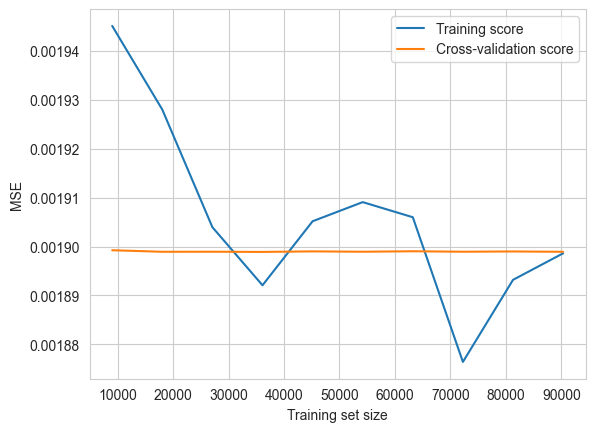

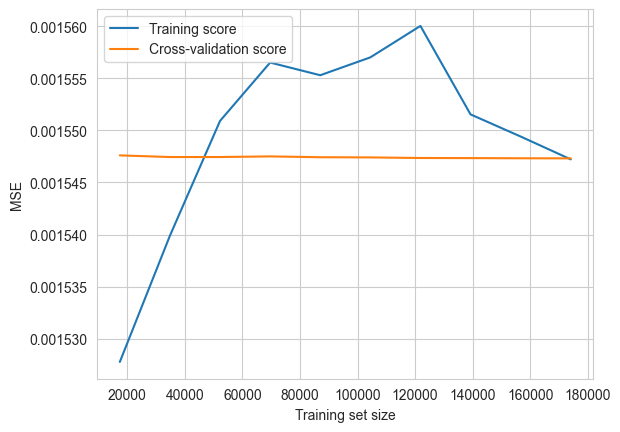

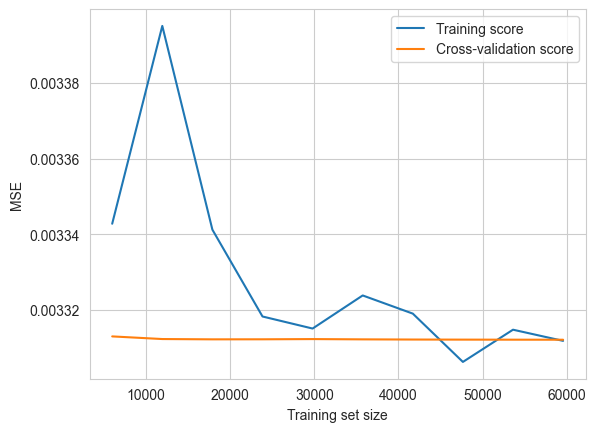

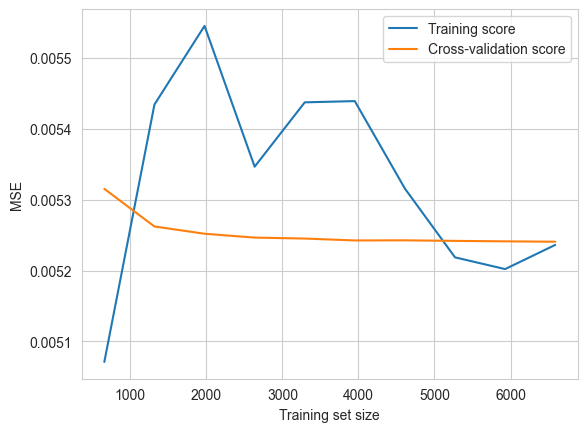

In [6]:
from sklearn.model_selection import learning_curve
for name, group in mb_frames_by_charge:
    X = X_list[name]
    y = Y_list[name]
    # Define the sizes of the training sets to use
    train_sizes = np.linspace(0.1, 1.0, 10)

    # Calculate the learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        LinearRegression(n_jobs=-1),
        X,
        y,
        train_sizes=train_sizes,
        cv=k,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    # Calculate the average training and test scores
    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    # Plot the learning curve
    plt.plot(train_sizes, train_scores_mean, label='Training score')
    plt.plot(train_sizes, test_scores_mean, label='Cross-validation score')
    plt.xlabel('Training set size')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()


Feature: 0, Score: -0.00067
Feature: 1, Score: 0.01429


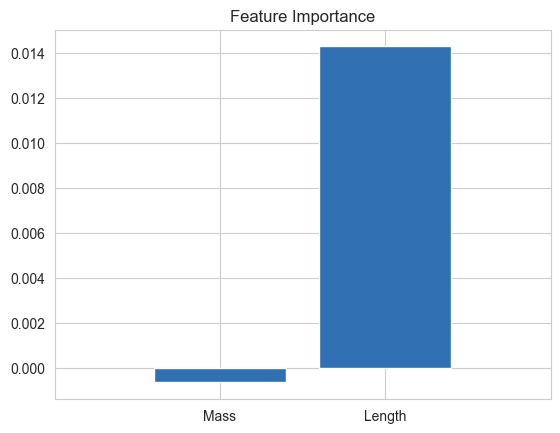

Feature: 0, Score: -0.00032
Feature: 1, Score: -0.00007


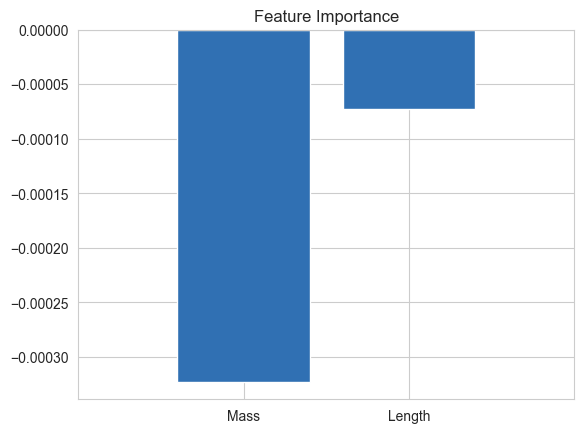

Feature: 0, Score: -0.00013
Feature: 1, Score: -0.00610


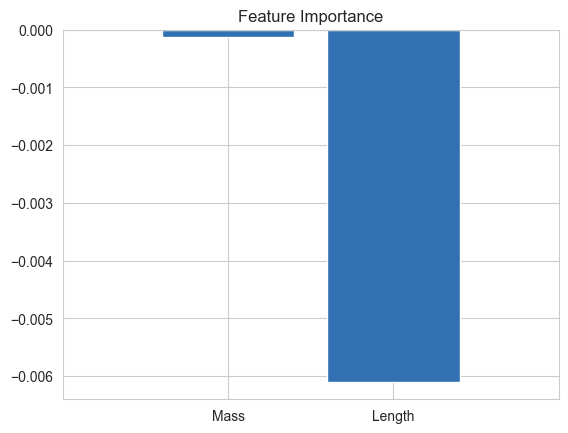

Feature: 0, Score: -0.00011
Feature: 1, Score: -0.00424


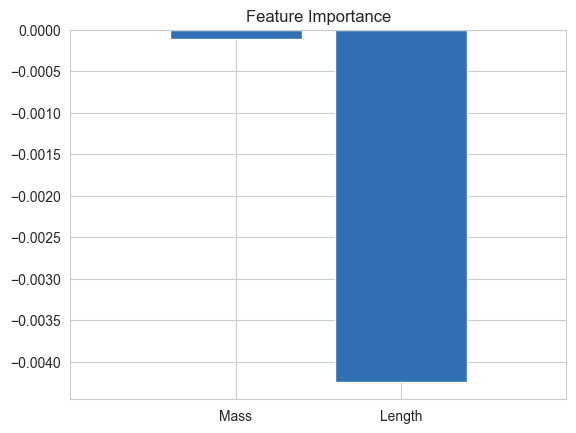

In [7]:
for name, group in mb_frames_by_charge:
    importance = scores_dict[name]["model"].coef_
    # summarize feature importance
    for i,v in enumerate(importance):
     print('Feature: %0d, Score: %.5f' % (i,v))

    # plot feature importance
    plt.bar([x for x in range(len(importance))], importance, color="#3070B3")
    plt.title("Feature Importance")
    features = X.columns
    plt.xticks(range(X.shape[1]), model.feature_names_in_, rotation=0)
    plt.xlim([-1, X.shape[1]])
    plt.show()

Save the model

In [8]:
for name, group in mb_frames_by_charge:

    # Add a column to the data frame with the length of each peptide sequence
    group['Sequence Length'] = group['Sequence'].apply(lambda x: len(x))
    # Predict the CCS of the peptides in the data frame
    group['Predicted CCS'] = final_model.predict(group[[ 'Mass', 'Length']])
    # Reverse the log transformation
    group['Predicted CCS'] = np.exp(group['Predicted CCS'])

Save the model to a file

In [9]:
#filename = '../../models/lin_reg/lin_reg.pkl'
#pickle.dump(model, open(filename, 'wb'))